In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path

2023-06-11 18:54:10.390291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 18:54:10.519361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 18:54:10.520424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 18:54:11.445344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_dir = Path("/home/davide/Documenti/Uni/Percezione/progetto/A. RFMiD_All_Classes_Dataset/Train Set Simplified")
validation_dir = Path("/home/davide/Documenti/Uni/Percezione/progetto/A. RFMiD_All_Classes_Dataset/Validation Set Simplified")
test_dir= Path("/home/davide/Documenti/Uni/Percezione/progetto/A. RFMiD_All_Classes_Dataset/Test Set Simplified")
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2078 files belonging to 2 classes.
Found 680 files belonging to 2 classes.
Found 640 files belonging to 2 classes.


In [3]:
class_names = train_ds.class_names
print(class_names)


['Malate', 'Sane']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_SIZE[0],
                                  IMG_SIZE[1],
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [18]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [20]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                  

In [10]:

imgfolder0 = Path(f"{train_dir}/Malate")
imgfolder1 = Path(f"{train_dir}/Sane")
image_count0 = len(list(imgfolder0.glob('*.png')))
image_count1 = len(list(imgfolder1.glob('*.png')))
weight_for_0 = (image_count0+image_count1)/image_count0
weight_for_1 = (image_count0+image_count1)/image_count1

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.24
Weight for class 1: 5.18


In [11]:

epochs = 15
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  class_weight=class_weight
)


Epoch 1/15


2023-06-11 18:54:49.609615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2078]
	 [[{{node Placeholder/_4}}]]
2023-06-11 18:54:49.610175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2078]
	 [[{{node Placeholder/_0}}]]
2023-06-11 18:55:01.648355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5 of 1000
2023-06-11 18:55:11.349629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 16 of 1000
2023-06-11 18:55:2

65/65 [==============================] - ETA: 0s - loss: 1.3684 - accuracy: 0.6270

2023-06-11 18:56:18.704250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]
2023-06-11 18:56:18.704850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]


65/65 [==============================] - 112s 758ms/step - loss: 1.3684 - accuracy: 0.6270 - val_loss: 0.6894 - val_accuracy: 0.3853
Epoch 2/15
65/65 [==============================] - 47s 731ms/step - loss: 1.3383 - accuracy: 0.5467 - val_loss: 0.7010 - val_accuracy: 0.3676
Epoch 3/15
65/65 [==============================] - 47s 733ms/step - loss: 1.3362 - accuracy: 0.5496 - val_loss: 0.7552 - val_accuracy: 0.3044
Epoch 4/15
65/65 [==============================] - 49s 764ms/step - loss: 1.3475 - accuracy: 0.4755 - val_loss: 0.4828 - val_accuracy: 0.7985
Epoch 5/15
65/65 [==============================] - 49s 764ms/step - loss: 1.2720 - accuracy: 0.4836 - val_loss: 0.6455 - val_accuracy: 0.4809
Epoch 6/15
65/65 [==============================] - 46s 719ms/step - loss: 1.3026 - accuracy: 0.4682 - val_loss: 0.7321 - val_accuracy: 0.2074
Epoch 7/15
65/65 [==============================] - 46s 714ms/step - loss: 1.3771 - accuracy: 0.4220 - val_loss: 0.6384 - val_accuracy: 0.6941
Epoch 8/1

In [12]:
"""fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds,
                         class_weight=class_weight)
                         """

'fine_tune_epochs = 10\ntotal_epochs =  epochs + fine_tune_epochs\nhistory_fine = model.fit(train_ds,\n                         epochs=total_epochs,\n                         initial_epoch=history.epoch[-1],\n                         validation_data=validation_ds,\n                         class_weight=class_weight)\n                         '

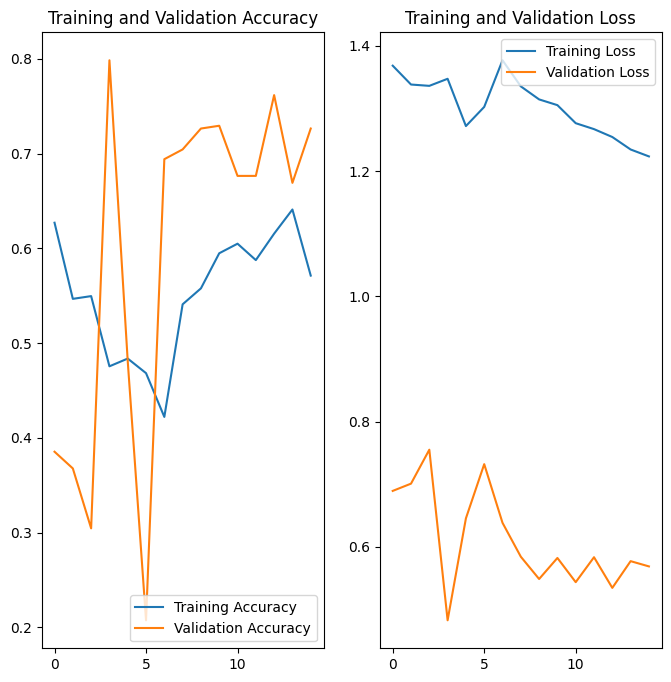

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


2023-06-11 19:23:51.964524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,160,160,3]
	 [[{{node Placeholder/_0}}]]


Predictions:
 [0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0]
Labels:
 [0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0]


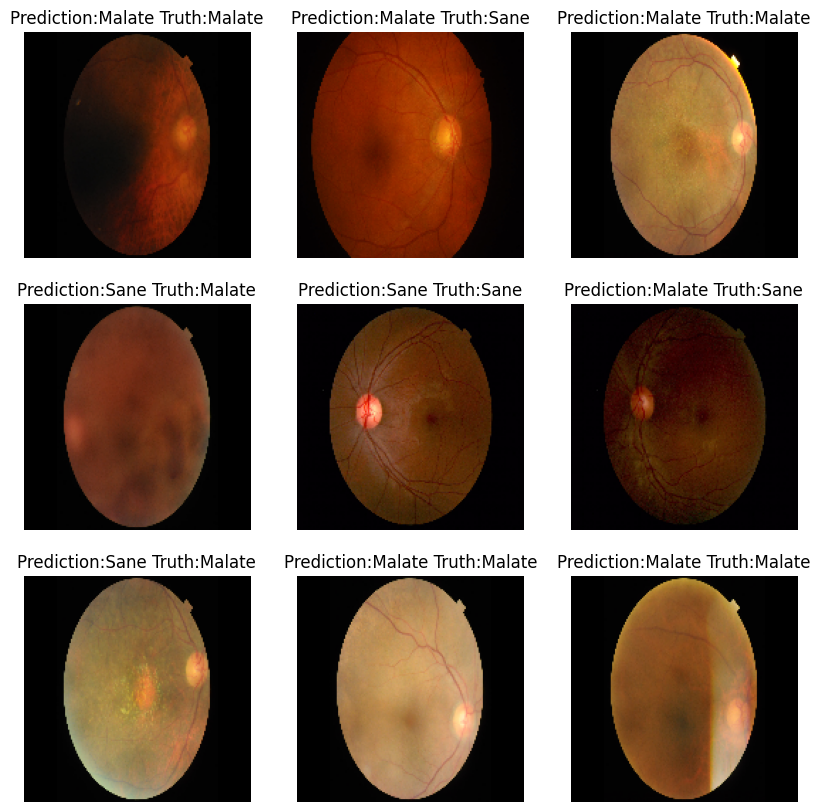

In [17]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"Prediction:{class_names[predictions[i]]} Truth:{class_names[label_batch[i]]}")
  plt.axis("off")